# Verify Frosty Dawgs Data Pipeline

This notebook graphs results from the Frosty Dawgs data pipeline, proccessing SWE and WRF data for one region: the Skagit region. It compares the results to data compiled from similar (but not exactly the same) data in a related project (The Prior Project).  The expectation is that the two data sources should look similar but are not expected to be identical.  

# Step 0 - Prepare the Notebook 

In [18]:
import pandas as pd
import boto3
import s3fs
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import io
import requests
from io import StringIO
import geopandas as gpd

# Step 1 - Import to Notebook "Model Ready" Data Produced by Frosty Dawgs Pipeline

In [19]:
# def some functions to get data from S3

def s3_to_ds(bucket_name, file_name):
    s3_path = f"s3://{bucket_name}/{file_name}"
    fs = s3fs.S3FileSystem(anon=False)
    with fs.open(s3_path) as f:
        ds = xr.open_dataset(f)
        ds.load()
    return ds

def s3_to_df(file_name, bucket_name):
    """
    Loads a CSV file from an S3 bucket into a pandas DataFrame.

    Parameters:
        file_name (str): The name of the CSV file in the S3 bucket.
        bucket_name (str): The name of the S3 bucket.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data from the CSV file.
    """
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    content = response['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(content))
    return df

In [20]:
# upload the data from S3 
bucket_name = "dawgs-model-ready"
huc_id = "17110005"    
sub_huc = '07'
full_huc = huc_id + sub_huc
print(full_huc)
#file_name = f"model_ready_{huc_lev}_in_{huc_id}.csv"
file_name = f"model_ready_huc{full_huc}.csv"
df_dawgs = s3_to_df(file_name, bucket_name)
df_dawgs.head()

1711000507


,day,mean_pr,mean_tair,mean_vs,mean_srad,mean_rmax,mean_rmin,mean_swe
0,1983-10-01,0.000000,4.553409,2.897727,95.138636,0.608091,0.327409,0.000227
1,1983-10-02,0.000000,5.088636,3.161364,130.086364,0.881273,0.489409,0.000091
2,1983-10-03,0.000809,5.394318,4.636364,86.400000,0.990000,0.609909,0.000000
3,1983-10-04,0.000152,4.397727,3.213636,170.377273,1.000000,0.566886,0.000000
4,1983-10-05,0.000000,4.535227,2.404545,135.420455,0.852682,0.449841,0.000000


Note no data in 0501, 0502, 0503 as they are in Canada


In [21]:
# some further processing

# Ensure the 'time' column is in datetime format
df_dawgs['day'] = pd.to_datetime(df_dawgs['day'])

# Filter rows where 'time' is after the year 1996
df_dawgs = df_dawgs[df_dawgs['day'] > '1996-01-01']

# Set time as the index 
df_dawgs_clean = df_dawgs.set_index('day')

# Display 
df_dawgs_clean.head()


,mean_pr,mean_tair,mean_vs,mean_srad,mean_rmax,mean_rmin,mean_swe
day,,,,,,,
1996-01-02,0.002747,1.228409,6.893182,34.000000,0.999932,0.771977,0.394841
1996-01-03,0.002871,-1.652273,5.675000,48.502273,1.000000,0.727568,0.401114
1996-01-04,0.000949,-5.572727,1.465909,28.434091,1.000000,0.700432,0.408136
1996-01-05,0.000685,-7.188636,3.438636,66.379545,0.999727,0.700023,0.516659
1996-01-06,0.003748,-1.545455,8.286364,34.665909,0.999500,0.703205,0.508614


Note on units.   
frosty_dawgs initial units 
 - swe is in mm H20: see https://nsidc.org/data/nsidc-0719/versions/1#anchor-documentation
 - precipitation_amount is in mm see https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET#bands
 - tmmx and tmmin (air_temperature) in degrees K see id 
 - vs (wind speed) in m/s
 - srad (solar radiation) in W/m^2
 - rhmin and rhmax (relative humidity) in %
units in model ready data 
- swe from mm -> m (/1000)
- air temp from K t0 C (-273.15)
- pr - pr/(100^2)

# Step 2 -Import to Notebook Data Used from Prior Project  

In [22]:
# mean SWE used in Prior Project collab notebook 
f = f"data_prior/wus-sr-skagit-{full_huc}-mean-swe.csv"
df_prior_swe = pd.read_csv(f)
df_prior_swe.rename(columns={'mean': 'mean_SWE'}, inplace=True)
df_prior_swe = df_prior_swe[["time", "mean_SWE"]]
df_prior_swe['time'] = pd.to_datetime(df_prior_swe['time'])
df_prior_swe = df_prior_swe[df_prior_swe['time'] >= '1996-10-01']
df_prior_swe.set_index('time', inplace=True)
print(df_prior_swe.shape)
df_prior_swe.head()


(9131, 1)


,mean_SWE
time,
1996-10-01,0.014087
1996-10-02,0.011417
1996-10-03,0.010064
1996-10-04,0.008764
1996-10-05,0.007963


In [23]:
# mean Wrf used in Prior Project collab notebook 
f = f"data_prior/wrf-skagit-{full_huc}-mean.csv"
df_prior_wrf = pd.read_csv(f)

df_prior_wrf['time'] = pd.to_datetime(df_prior_wrf['time'])

# Filter rows where 'time' is after the year 1996
df_prior_wrf = df_prior_wrf[df_prior_wrf['time'] > '1996-10-01']

#set time as index
df_prior_wrf = df_prior_wrf.set_index('time')
df_prior_wrf.head()

,spatial_ref,lw,precip,rh,sw,tair,wind
time,,,,,,,
1996-10-01 03:00:00,0,234.894158,0.0,93.653684,0.000000,0.030684,1.885474
1996-10-01 06:00:00,0,241.335158,0.0,81.658684,174.117474,1.915947,1.885474
1996-10-01 09:00:00,0,266.563947,0.0,50.862105,512.858737,8.904211,1.885474
1996-10-01 12:00:00,0,289.063789,0.0,35.098316,521.800316,14.717053,1.885474
1996-10-01 15:00:00,0,289.480737,0.0,35.463158,192.906526,14.751316,1.885474


# Plotting

In [24]:
# define plotting functions

def plot_var(df1, df2, var1, var2, time_period): 
    plt.figure(figsize=(8, 4))
    plt.plot(df1.index, df1[var1], label= "Prior Project", color='blue', linewidth=2)
    plt.plot(df2.index, df2[var2], label ='Frosty Dawgs', color='red', linewidth=2)
    

    # Add labels and title
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(var1, fontsize=12)
    plt.title(f'{var1} vs. Time for {time_period} huc: {full_huc}', fontsize=14)

    # Improve plot appearance
    #plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def plot_var_stacked(df1, df2, var1, var2, time_period):
    # Set up the figure with two subplots (vertically stacked)
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

    # First plot (df1)
    axes[0].plot(df1.index, df1[var1], label=f'{var1}_prior_project', color='blue', linewidth=2)
    axes[0].set_ylabel(var1, fontsize=12)
    axes[0].set_title(f"{var1} vs. Time (Collab Notebook) for {time_period} huc: {full_huc}", fontsize=14)
    axes[0].legend(fontsize=10)

    # Second plot (df2)
    # TO DO - FIX HARD CODE OF COL 
    axes[1].plot(df2.index, df2[var2], label=f'{var2} Dawgs Pipeline', color='red', linewidth=2)
    axes[1].set_xlabel('Time', fontsize=12)
    axes[1].set_ylabel(f'Mean {var2}', fontsize=12)
    axes[1].set_title(f'Mean {var2} vs. Time (Sues Pipeline) for {time_period} huc: {full_huc}', fontsize=14)
    axes[1].legend(fontsize=10)

    # Improve plot appearance
    for ax in axes:
        ax.grid(visible=True, linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout()

    # Show the plot



# Plot comparing Swe Datasources

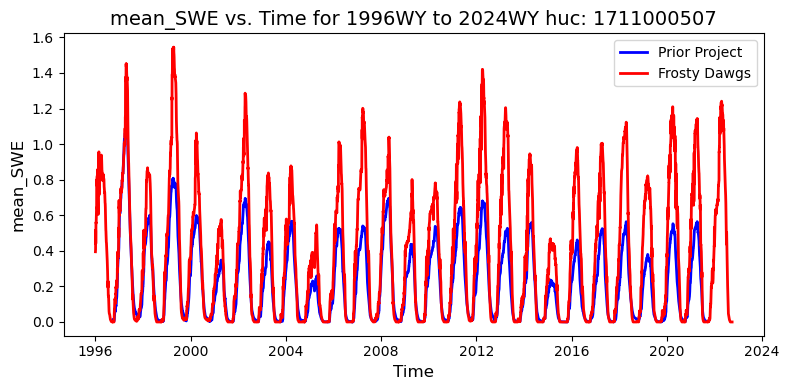

In [25]:
time_period = "1996WY to 2024WY"
var1 = "mean_SWE"
var2 = "mean_swe"
plot_var(df_prior_swe, df_dawgs_clean, var1, var2, time_period)

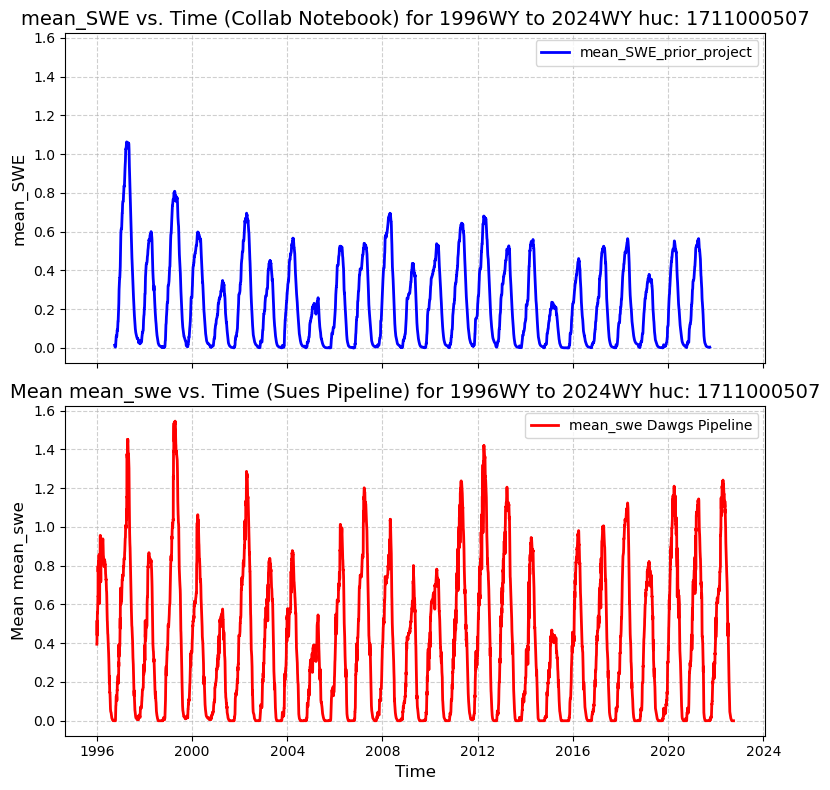

In [27]:
time_period = "1996WY to 2024WY"
var1 = "mean_SWE"
var2 = "mean_swe"
plot_var_stacked(df_prior_swe, df_dawgs_clean, var1, var2, time_period)

# Plot Comparing Precipitation 

In [28]:
df_prior_pr = pd.DataFrame(df_prior_wrf.resample('D')['precip'].mean())
df_prior_pr.rename(columns={'precip': 'mean_pr'}, inplace=True)
df_prior_pr.head(2)

,mean_pr
time,
1996-10-01,0.000000
1996-10-02,0.000008


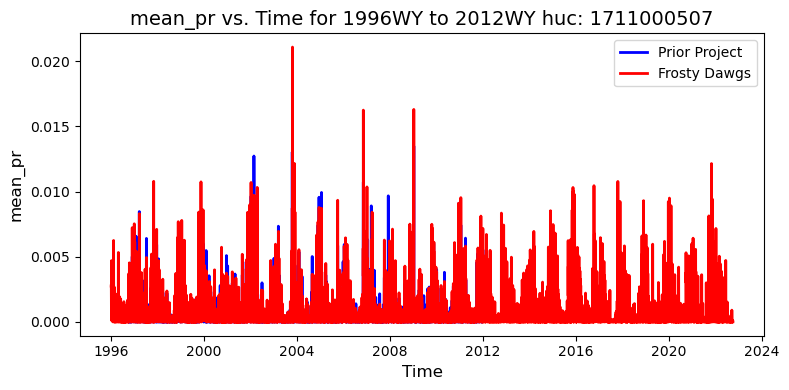

In [29]:
time_period = "1996WY to 2012WY"
var1 = "mean_pr"
var2 = "mean_pr"
plot_var(df_prior_pr, df_dawgs_clean, var1, var2,  time_period)

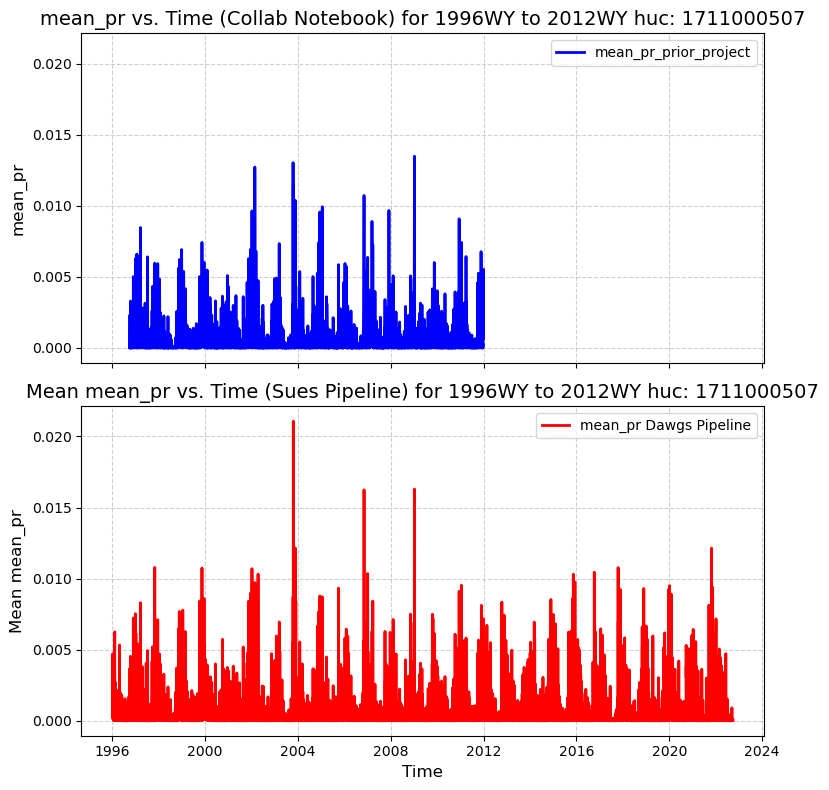

In [30]:
time_period = "1996WY to 2012WY"
plot_var_stacked(df_prior_pr, df_dawgs_clean, var1, var2, time_period)

# Plot comparing cumulative precip 

In [31]:

# Definition to calculate a column for cumulative precipitation

def df_to_cumulative_pr (df, var):
    df['water_year'] = df.index.to_series().apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
    # Calculate the cumulative precipitation within each water year
    df['cumulative_pr'] = df.groupby('water_year')[var].cumsum()
    return df 

In [32]:
df_dawgs_cum = df_to_cumulative_pr(df_dawgs_clean, "mean_pr")
df_dawgs_cum.head(5)


,mean_pr,mean_tair,mean_vs,mean_srad,mean_rmax,mean_rmin,mean_swe,water_year,cumulative_pr
day,,,,,,,,,
1996-01-02,0.002747,1.228409,6.893182,34.000000,0.999932,0.771977,0.394841,1996,0.002747
1996-01-03,0.002871,-1.652273,5.675000,48.502273,1.000000,0.727568,0.401114,1996,0.005618
1996-01-04,0.000949,-5.572727,1.465909,28.434091,1.000000,0.700432,0.408136,1996,0.006567
1996-01-05,0.000685,-7.188636,3.438636,66.379545,0.999727,0.700023,0.516659,1996,0.007253
1996-01-06,0.003748,-1.545455,8.286364,34.665909,0.999500,0.703205,0.508614,1996,0.011001


In [33]:
df_prior_cum = df_to_cumulative_pr(df_prior_pr, "mean_pr")
df_prior_cum.head(5)

,mean_pr,water_year,cumulative_pr
time,,,
1996-10-01,0.000000,1997,0.000000
1996-10-02,0.000008,1997,0.000008
1996-10-03,0.000365,1997,0.000373
1996-10-04,0.002322,1997,0.002695
1996-10-05,0.001255,1997,0.003949


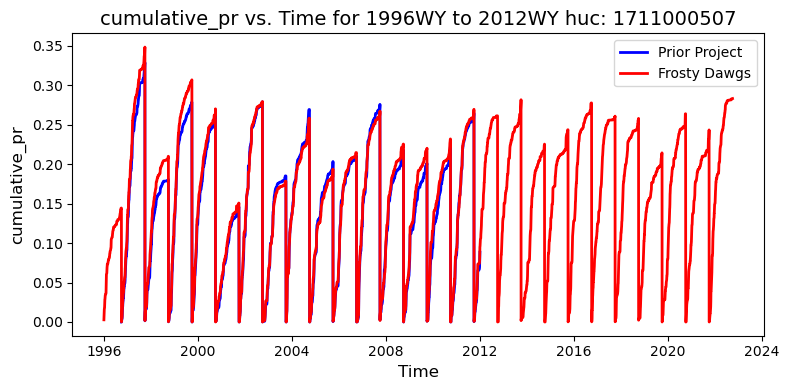

In [34]:
plot_var(df_prior_pr, df_dawgs_clean, "cumulative_pr", "cumulative_pr", time_period)

# Plot AIR TEMP

In [35]:
df_prior_tair = pd.DataFrame(df_prior_wrf.resample('D')['tair'].mean())
df_prior_tair.head(2)


,tair
time,
1996-10-01,8.492917
1996-10-02,7.420118


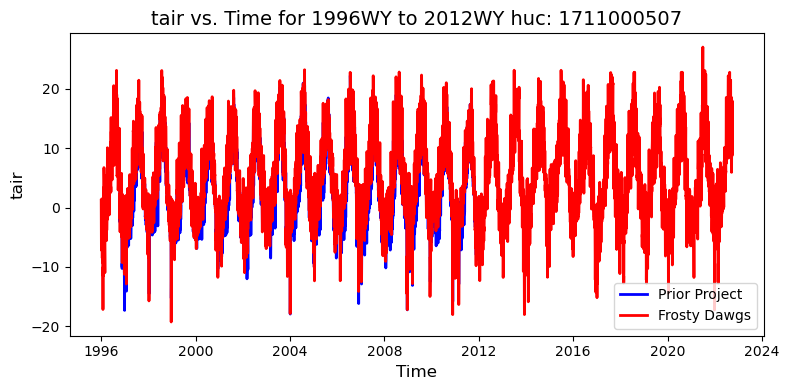

In [37]:
var1 = "tair"
var2 = "mean_tair"
plot_var(df_prior_tair, df_dawgs_clean, var1, var2, time_period)

# Plot Wind

In [38]:
df_prior_wind = pd.DataFrame(df_prior_wrf.resample('D')['wind'].mean())
df_prior_wind.head(2)

,wind
time,
1996-10-01,1.885474
1996-10-02,3.699421


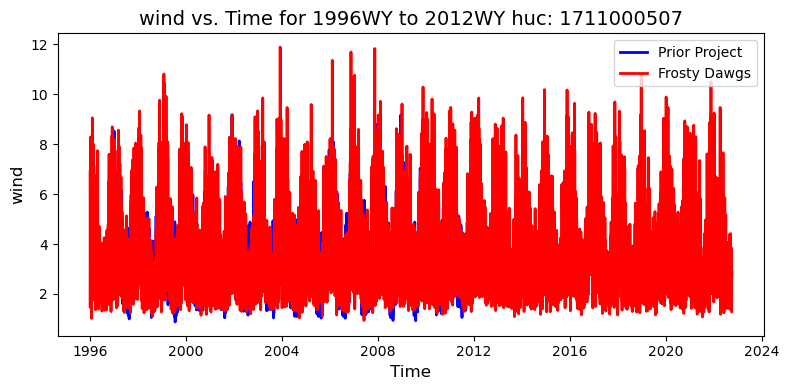

In [39]:
var1 = "wind"
var2 = "mean_vs"
plot_var(df_prior_wind, df_dawgs_clean, var1, var2, time_period)

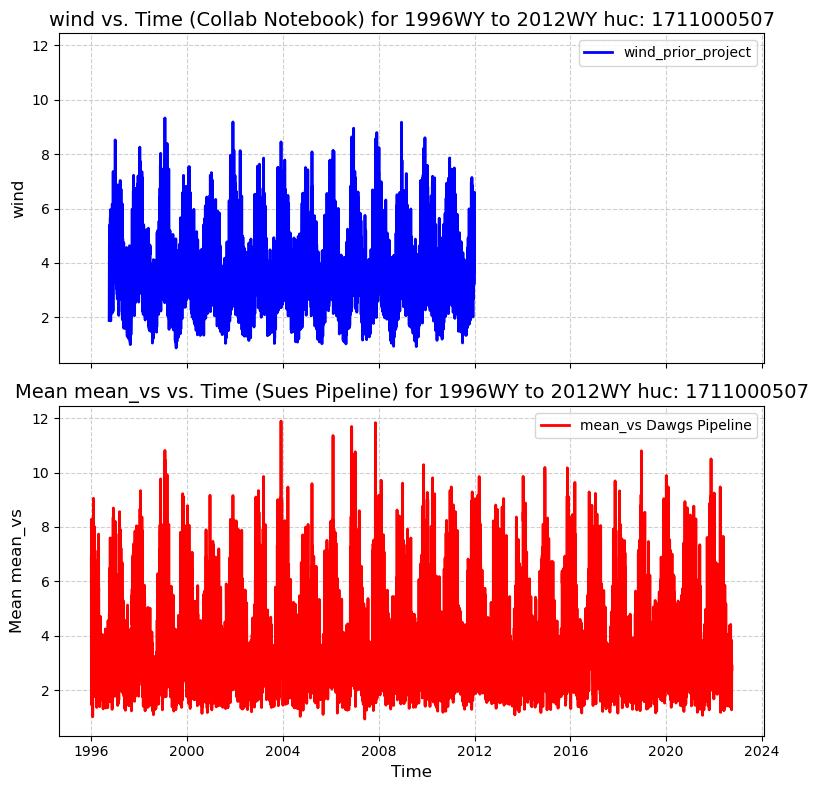

In [40]:
plot_var_stacked(df_prior_wind, df_dawgs_clean, var1, var2, time_period)

# Plot Short Wave Radiation 

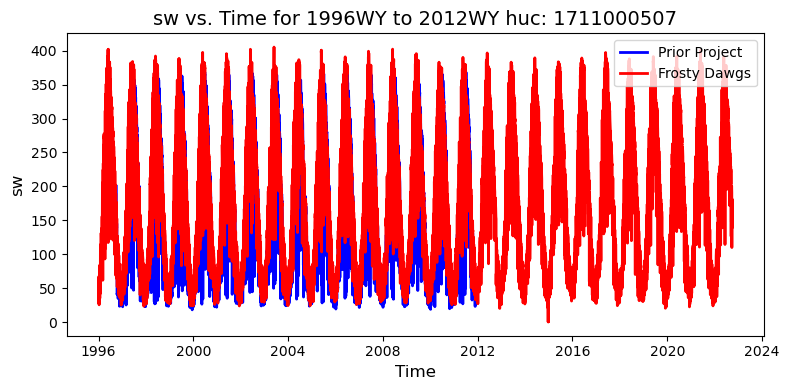

In [41]:
df_prior_sr = pd.DataFrame(df_prior_wrf.resample('D')['sw'].mean())
var1 = "sw"
var2 = "mean_srad"
plot_var(df_prior_sr, df_dawgs_clean, var1, var2, time_period)

In [ ]:
plot_var_stacked(df_prior_sr, df_dawgs_clean, var1, var2, time_period)

# Plot Humidity 

In [ ]:
df_prior_rh = pd.DataFrame(df_prior_wrf.resample('D')['rh'].mean())
var1 = "rh"
var2 = "mean_rmin"
plot_var(df_prior_rh, df_dawgs_clean, var1, var2, time_period)

# Plot Skagit

In [ ]:

def s3_to_gdf(bucket_name, file_name, region_name="us-east-1"):

    s3_client = boto3.client("s3", region_name=region_name)
    
    # Download the file from S3 into a bytes buffer
    try:
        buffer = io.BytesIO()
        s3_client.download_fileobj(bucket_name, file_name, buffer)
        buffer.seek(0)  # Reset buffer position to the beginning

        # Read the file into a GeoDataFrame (assuming GeoJSON format)
        geos = gpd.read_file(buffer)

        return geos
    
    except Exception as e:
        print(f"Error downloading or reading file from S3: {e}")
        return None

In [ ]:
b = "shape-bronze"
f = "Huc10_in_17110005.geojson"
geos = s3_to_gdf(b, f)
geos

In [ ]:
geos.explore()